In [37]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import random
import torch
import warnings 
warnings.filterwarnings('ignore')
from pytorch_lightning import seed_everything
import os
import gc
gc.collect()

3422

# set_seed(42)

In [38]:
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
random_state = set_seed(42)

Global seed set to 42


# MADGRAD

In [39]:
import math
from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(Optimizer):

    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, weight_decay: float = 0, eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:

        loss = None
        if closure is not None:
            loss = closure()

        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss

# LOAD DATA

In [40]:
import os
os.listdir()

['Product_Data_summarize(undone).ipynb',
 'preprocess_for_SQUAD.csv',
 'Train_Product_Data_2021_0114.csv',
 'Product_Data_SQuAD_knowledge distillation V2.ipynb',
 '全部集合.txt.gz',
 'Product_Data_ner.ipynb',
 'submit.csv',
 'Product_Data_SQuAD_model_V2.pt',
 'EDA.ipynb',
 '台塑企業_ 產品寶典20210303.xlsx',
 'aclImdb',
 'preprocess_for_SQUAD_wordninja.csv',
 'load_model_and_test-V2.ipynb',
 '產品集合.txt',
 'load_model_and_test.ipynb',
 'aclImdb_v1.tar.gz',
 'Collection method.ipynb',
 'Product_Data_SQuAD_knowledge distillation.ipynb',
 '斷詞.ipynb',
 'Product_Data_SQuAD_V2.ipynb',
 'Val_Product_Data_2021_0114.csv',
 'wordninja_words.txt',
 'Product_Data_SQuAD_model.pt',
 'squad_finetuning_example.ipynb',
 '全部集合.txt',
 'Product_Data_SQuAD.ipynb',
 '.ipynb_checkpoints']

In [41]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('preprocess_for_SQUAD_wordninja.csv',index_col=0)[['45A','Y_label','string_Y_1','string_Y_2']].dropna(axis=0)
df.iloc[:,-2:] = df.iloc[:,-2:].astype(int)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df = df.rename(columns={'45A':'string_X_train'})
train_df, val_df = train_test_split(df,test_size=0.3,random_state=42)
display(train_df.head(100))
display(val_df.head(100))

,string_X_train,Y_label,string_Y_1,string_Y_2
3,COMMODITY DIETHYLENE GLYCOL DEG QUANTITY 1000 ...,DIETHYLENE GLYCOL DEG,10,31
417,1 COMMODITY POLYPROPYLENE YUNGSOX 1990 QUANTIT...,POLYPROPYLENE YUNGSOX 1990,12,38
173,TRADE TERM CFR ZHU HAI CHINA COMMODITY MONOETH...,MONOETHYLENE GLYCOLMEG,39,61
60,COMMODITY MONOETHYLENE GLYCOL MEG FIBER GRADE ...,MONOETHYLENE GLYCOL MEG FIBER GRADE,10,45
110,80 X 195 KGS NET NEW EXPORT WORTHY PLASTIC DRU...,METHACRYLIC ACID,73,89
...,...,...,...,...
249,METHYLENE CHLORIDE 9750 MT PACKING 260 KG DRUM...,METHYLENE CHLORIDE,0,18
266,COMMODITY MONO ETHYLENE GLYCOL MEG QUANTITY 25...,MONO ETHYLENE GLYCOL MEG,10,34
194,COMMODITY MONOETHYLENE GLYCOL MEG FIBER GRADE ...,MONOETHYLENE GLYCOL MEG FIBER GRADE,10,45
89,METHACRYLIC ACID 99 PCT MIN Q TY 2 FC L EQUAL ...,METHACRYLIC ACID,0,16


,string_X_train,Y_label,string_Y_1,string_Y_2
72,FREE FOAMED PVC SHEET 900000 PCS 30 MMX 910 MM...,FREE FOAMED PVC SHEET,0,21
244,TERMS OF PRICE CFR ZHANG JIA GANG CHINA COMMOD...,DIETHYLENE GLYCOL DEG,50,71
437,COMMODITY MONO ETHYLENE GLYCOL QUANTITY 100000...,MONO ETHYLENE GLYCOL,10,30
79,COMMODITY MONO ETHYLENE GLYCOL MEG FIBER GRADE...,MONO ETHYLENE GLYCOL MEG FIBER GRADE,10,46
402,COMMODITY MONO ETHYLENE GLYCOL MEG QUANTITY 10...,MONO ETHYLENE GLYCOL MEG,10,34
...,...,...,...,...
324,C IF JAPAN MAIN PORT OR AIRPORT GLASS FABRICS,GLASS FABRICS,32,45
398,COPPER CLAD LAMINATES 8200 SHEET SAS PER PURCH...,COPPER CLAD LAMINATES,0,21
399,60 MT OF MALEIC ANHYDRIDE BRIQUETTE TYPE AT US...,MALEIC ANHYDRIDE,9,25
415,COMMODITY MONO ETHYLENE GLYCOL MEG FIBER GRADE...,MONO ETHYLENE GLYCOL MEG FIBER GRADE,10,46


# find_fail_sample and drop fail_sample

In [42]:
def find_fail_sample(df):
    fails = []
    for i in df.index:
        context = df.loc[i,'string_X_train']
        answer = df.loc[i,'Y_label']
        if answer not in context:
            fails.append(i)
    return fails
train_fails = find_fail_sample(train_df)
val_fails = find_fail_sample(val_df)
print(train_fails,val_fails)
display(val_df.loc[val_fails])
print(train_df.shape)
train_df = train_df.drop(train_fails,axis=0)
print(train_df.shape)
print(val_df.shape)
val_df = val_df.drop(val_fails,axis=0)
print(val_df.shape)

[] []


,string_X_train,Y_label,string_Y_1,string_Y_2


(341, 4)
(341, 4)
(147, 4)
(147, 4)


# Model and Tokenizer Initialization

In [43]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
gc.collect()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

223

# Data preprocessing

In [44]:
def preprocessing(df):
    contexts = df['string_X_train'].values.tolist()
    questions = [ 'What is the product name?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

train_contexts ,train_questions ,train_answers = preprocessing(train_df)
val_contexts ,val_questions ,val_answers = preprocessing(val_df)
gc.collect()

0

# tokenize our context/question pairs

In [45]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
gc.collect()

0

# add_token_positions

In [46]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)
gc.collect()

20

# data is ready put it in a PyTorch dataset

In [47]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)
gc.collect()

20

# train loop

In [48]:
from torch.utils.data import DataLoader

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)
model.train()
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True ,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=True ,num_workers=4)
optimizer = MADGRAD(model.parameters(),lr=5e-5)
gc.collect()

def train_step(model,batch,optimizer):
    model = model.to(device)
    model.train()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    # update model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    gc.collect()
    return loss.item()

def val_step(model,batch,optimizer):
    model = model.to(device)
    model.eval()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    gc.collect()
    return loss.item()

def train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    not_improve_count = 0
    for epoch in tqdm(range(max_epochs)):    
        # reset this epoch loss equal to zero
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        # train one epoch and get train_loss
        for i,batch in enumerate(tqdm(train_loader)):
            epoch_train_loss += train_step(model,batch,optimizer)

        # val one epoch and get val_loss
        for j,batch in enumerate(tqdm(val_loader)):
            epoch_val_loss += val_step(model,batch,optimizer)

        # record loss history
        history['train_loss'].append(epoch_train_loss/i)
        history['val_loss'].append(epoch_val_loss/j)

        # print this epoch's infomation
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/i} val_loss:{epoch_val_loss/j}')

        # save best_model (if current val_loss <= best_loss)
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')

        if history['val_loss'][-1] > best_loss:
            not_improve_count += 1
            print(f'not_improve_count:{not_improve_count}')
            if not_improve_count > patience:
                print('early_stoping')
                break

    # GET best_model.eval()
    model = best_model.eval()
    return model,history

cuda


In [49]:
model,history = train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch:0 train_loss:4.262399446964264 val_loss:1.8128174841403961
save best_model now_val_best_loss is:1.8128174841403961


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch:1 train_loss:0.6912021651864052 val_loss:0.1990965772420168
save best_model now_val_best_loss is:0.1990965772420168


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch:2 train_loss:0.09687328971922397 val_loss:0.1597501034848392
save best_model now_val_best_loss is:0.1597501034848392


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch:3 train_loss:0.06537443017587066 val_loss:0.10840731614734977
save best_model now_val_best_loss is:0.10840731614734977


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch:4 train_loss:0.03636311236768961 val_loss:0.15532516804523766
not_improve_count:1


# loss curve

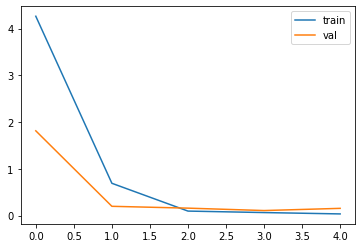

In [50]:
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.legend()
plt.show()

# question-answering pipeline

In [51]:
from transformers import pipeline
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

# test

In [52]:
def test_model(df):
    table = pd.DataFrame()
    for i in tqdm(df.index):
        sample = df.loc[[i]]
        string_X_train = sample['string_X_train'].values[0]
        string_Y_1 = sample['string_Y_1'].values[0]
        string_Y_2 = sample['string_Y_2'].values[0]
        QA_input = {
            'question': 'What is the product name?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][res['start']:res['end']]
        row = pd.DataFrame({
            'label':string_X_train[string_Y_1:string_Y_2],
            'predict:':predict},index=[i])
        if string_X_train[string_Y_1:string_Y_2] == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
        i += 1
    return table

# 最後讓我們來看看模型在驗證集上的表現

In [53]:
all_res = test_model(val_df)
all_res

  0%|          | 0/147 [00:00<?, ?it/s]

,label,predict:,是否全對
72,FREE FOAMED PVC SHEET,FREE FOAMED PVC SHEET,Yes
244,DIETHYLENE GLYCOL DEG,DIETHYLENE GLYCOL DEG,Yes
437,MONO ETHYLENE GLYCOL,MONO ETHYLENE GLYCOL,Yes
79,MONO ETHYLENE GLYCOL MEG FIBER GRADE,MONO ETHYLENE GLYCOL MEG FIBER GRADE,Yes
402,MONO ETHYLENE GLYCOL MEG,MONO ETHYLENE GLYCOL MEG,Yes
...,...,...,...
116,DIETHYLENE GLYCOL DEG A GRADE,DIETHYLENE GLYCOL DEG A GRADE,Yes
45,PVC RESIN S65,PVC RESIN S65,Yes
16,DIETHYLENE GLYCOL DEG,DIETHYLENE GLYCOL DEG,Yes
451,COPPER FOIL,COPPER FOIL,Yes


# claculate acc and jaccard

In [54]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

display(all_res['是否全對'].value_counts())
acc = all_res['是否全對'].value_counts()['Yes']/len(val_df)
print('acc:',acc)
jaccard_avg_score = np.mean([ get_jaccard_sim(all_res.label.loc[i],all_res['predict:'].loc[i]) for i in all_res.index])
print('jaccard_avg_score:',jaccard_avg_score)

Yes    140
No       7
Name: 是否全對, dtype: int64

acc: 0.9523809523809523
jaccard_avg_score: 0.9727891156462585
